In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

print("PyTorch versiyon:", torch.__version__)

DATA_DIR = r"C:\Users\Hp\Desktop\derinogr"

IMG_DIR = os.path.join(DATA_DIR, "images")
ANN_DIR = os.path.join(DATA_DIR, "annotations")
train_csv_path = os.path.join(ANN_DIR, "annotations_train.csv")

print("Görüntü klasörü:", IMG_DIR)
print("Annotation CSV yolu:", train_csv_path)

df = pd.read_csv(train_csv_path, header=None)
print("Toplam annotation satırı:", len(df))
print(df.head())


PyTorch versiyon: 2.9.1+cpu
Görüntü klasörü: C:\Users\Hp\Desktop\derinogr\images
Annotation CSV yolu: C:\Users\Hp\Desktop\derinogr\annotations\annotations_train.csv
Toplam annotation satırı: 1208482
             0     1     2     3     4       5     6     7
0  train_0.jpg   208   537   422   814  object  3024  3024
1  train_0.jpg  1268  1923  1365  2209  object  3024  3024
2  train_0.jpg  1135  2074  1261  2166  object  3024  3024
3  train_0.jpg  1045  2085  1122  2258  object  3024  3024
4  train_0.jpg   976  2036  1040  2177  object  3024  3024


In [2]:
# CSV kolonları:
# 0: image_name, 1:x1, 2:y1, 3:x2, 4:y2, 5:class, 6:width, 7:height

grouped = df.groupby(0)

samples = []
for img_name, g in grouped:
    row = g.iloc[0]   # o resme ait ilk bounding box
    x1, y1, x2, y2 = row[1], row[2], row[3], row[4]
    img_w, img_h = row[6], row[7]
    samples.append((img_name, x1, y1, x2, y2, img_w, img_h))

print("Toplam görüntü (sample):", len(samples))
print("İlk örnek:", samples[0])

samples_small = samples[:2000]
print("Kullanılacak örnek sayısı:", len(samples_small))


Toplam görüntü (sample): 8219
İlk örnek: ('train_0.jpg', np.int64(208), np.int64(537), np.int64(422), np.int64(814), np.int64(3024), np.int64(3024))
Kullanılacak örnek sayısı: 2000


In [3]:
IMG_SIZE = 256

class ShelfSingleBoxDataset(Dataset):
    def __init__(self, samples, img_dir, img_size=256):
        self.samples = samples
        self.img_dir = img_dir
        self.img_size = img_size

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, x1, y1, x2, y2, img_w, img_h = self.samples[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # resmi oku
        img = Image.open(img_path).convert("RGB")
        img = img.resize((self.img_size, self.img_size))
        img_np = np.array(img, dtype=np.float32) / 255.0  
        img_np = np.transpose(img_np, (2, 0, 1))          
        img_tensor = torch.tensor(img_np, dtype=torch.float32)

        #normalize et 
        x1_n = x1 / img_w
        y1_n = y1 / img_h
        x2_n = x2 / img_w
        y2_n = y2 / img_h

        target = torch.tensor([x1_n, y1_n, x2_n, y2_n], dtype=torch.float32)

        return img_tensor, target

dataset = ShelfSingleBoxDataset(samples_small, IMG_DIR, IMG_SIZE)
print("Dataset uzunluğu:", len(dataset))

img_ex, target_ex = dataset[0]
print("Örnek image shape:", img_ex.shape)
print("Örnek target:", target_ex)


Dataset uzunluğu: 2000
Örnek image shape: torch.Size([3, 256, 256])
Örnek target: tensor([0.0688, 0.1776, 0.1396, 0.2692])


In [4]:
BATCH_SIZE = 8

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

batch_imgs, batch_targets = next(iter(train_loader))
print("batch_imgs shape:", batch_imgs.shape)        
print("batch_targets shape:", batch_targets.shape) 


batch_imgs shape: torch.Size([8, 3, 256, 256])
batch_targets shape: torch.Size([8, 4])


In [5]:
import torch
import torch.nn as nn

class TinyGAPNet(nn.Module):
    def __init__(self):
        super(TinyGAPNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # ortalama al
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        # Regresyon kısmı
        self.regressor = nn.Sequential(
            nn.Flatten(),       
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
            nn.Sigmoid()         
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.regressor(x)
        return x

model = TinyGAPNet()
print(model)

# Dummy test
dummy = torch.randn(1, 3, 256, 256)
out = model(dummy)
print("Dummy çıktı shape:", out.shape)  # (1,4)


TinyGAPNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (regressor): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=4, bias=True)
  

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

model = TinyGAPNet().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 3
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for imgs, targets in train_loader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)           
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        loss_history.append(loss.item())

    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f}")


Kullanılan cihaz: cpu
Epoch 1/3 - Loss: 0.0651
Epoch 2/3 - Loss: 0.0650
Epoch 3/3 - Loss: 0.0650


In [7]:
MODEL_PATH = "tinygapnet_sku110k.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model kaydedildi:", MODEL_PATH)


Model kaydedildi: tinygapnet_sku110k.pth


In [8]:
def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_w = max(0.0, x2 - x1)
    inter_h = max(0.0, y2 - y1)
    inter = inter_w * inter_h

    area1 = max(0.0, box1[2] - box1[0]) * max(0.0, box1[3] - box1[1])
    area2 = max(0.0, box2[2] - box2[0]) * max(0.0, box2[3] - box2[1])

    union = area1 + area2 - inter + 1e-6
    return inter / union

ious = []
model.eval()

with torch.no_grad():
    for i, (imgs, targets) in enumerate(train_loader):
        imgs = imgs.to(device)
        preds = model(imgs).cpu().numpy()
        gts = targets.cpu().numpy()

        for gt, pr in zip(gts, preds):
            ious.append(iou(gt, pr))

        if i >= 9:  # sadece ilk 10 batch için
            break

print("Örneklerde Ortalama IoU:", float(np.mean(ious)))


Örneklerde Ortalama IoU: 0.0


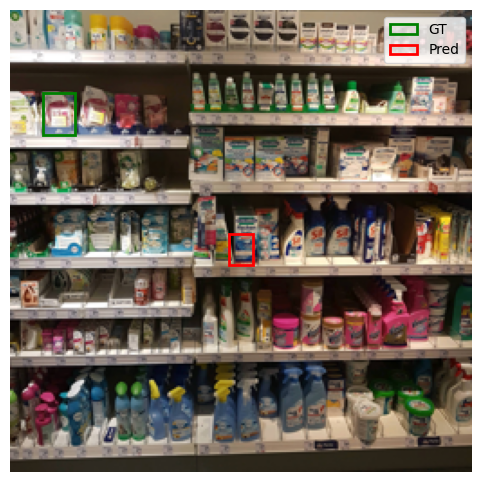

In [9]:
import matplotlib.patches as patches

# İlk örneği al
img_name, x1, y1, x2, y2, img_w, img_h = samples_small[0]
img_path = os.path.join(IMG_DIR, img_name)

# Gerçek kutuyu normalize et
gt_box_norm = np.array([x1/img_w, y1/img_h, x2/img_w, y2/img_h], dtype=np.float32)

# Görseli hazırla
img_orig = Image.open(img_path).convert("RGB")
img_resized = img_orig.resize((IMG_SIZE, IMG_SIZE))
img_np = np.array(img_resized, dtype=np.float32) / 255.0
img_tensor = torch.from_numpy(img_np).permute(2,0,1).unsqueeze(0).to(device)

# Model tahmini
model.eval()
with torch.no_grad():
    pred_norm = model(img_tensor).cpu().numpy()[0]

# Normalize kutuları piksele çevir 
gt_x1, gt_y1, gt_x2, gt_y2 = gt_box_norm * IMG_SIZE
pr_x1, pr_y1, pr_x2, pr_y2 = pred_norm * IMG_SIZE

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(img_resized)

# Gerçek kutu (yeşil)
ax.add_patch(patches.Rectangle(
    (gt_x1, gt_y1),
    gt_x2 - gt_x1,
    gt_y2 - gt_y1,
    linewidth=2,
    edgecolor='g',
    facecolor='none',
    label="GT"
))

# Tahmin kutusu (kırmızı)
ax.add_patch(patches.Rectangle(
    (pr_x1, pr_y1),
    pr_x2 - pr_x1,
    pr_y2 - pr_y1,
    linewidth=2,
    edgecolor='r',
    facecolor='none',
    label="Pred"
))

ax.legend()
plt.axis("off")
plt.show()
